In [42]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    RandomizedSearchCV,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score

### Data Cleaning and Preprocessing

In [4]:
gamelog_df = pd.read_csv("data/gamelogs.csv")
gamelog_df.shape

(7314, 67)

We first drop `goalsFor`, `goalsAgainst` since they are essentially what we are predicting. Furthermore, Some of the features are redundant and will me perfectly collinear with one another since a few features are a combination of context specific features (e.g. xGoalsFor is a combination of powerplay, shorthanded other and 5v5 xgoals). Thus, we will drop  `lowDangerxGoalsFor`,`mediumDangerxGoalsFor`, `highDangerxGoalsFor`, `lowDangerxGoalsAgainst`, `mediumDangerxGoalsAgainst`, `highDangerxGoalsAgainst`, `lowDangerGoalsFor`,`mediumDangerGoalsFor`, `highDangerGoalsFor`, `lowDangerGoalsAgainst`, `mediumDangerGoalsAgainst`, `highDangerGoalsAgainst`, `lowDangerShotsFor`, `mediumDangerShotsFor`, `highDangerShotsFor`, `lowDangerShotsAgainst`, `mediumDangerShotsAgainst`, and `highDangerShotsAgainst` since expected goals already accounts for shot quality thus shot quality specifc data would be redundant. Moreover, we also drop `savedShotsOnGoalFor`, and `savedShotsOnGoalAgainst` since they are dependent on shots on goal for/against. We also remove all corsi and fenwick percentage columns as they are a combination of shots on goal, shots blocked and other attempted shots; however, blocked and missed shot attempts likely do not have strong preditcive power for whether a team wins or loses thus we will focus on shots on goal and blocked shots specifically.

In [5]:
gamelog_features = gamelog_df.drop(columns = ["home_or_away", "situation","fenwickPercentage", "corsiPercentage", "xGoalsFor",
                                    "xGoalsAgainst", "goalsFor", "goalsAgainst", "last_10_avg_xgoals_for", 
                                    "last_10_avg_xgoals_against","lowDangerxGoalsFor","mediumDangerxGoalsFor", 
                                    "highDangerxGoalsFor", "lowDangerxGoalsAgainst",
                                    "mediumDangerxGoalsAgainst", "highDangerxGoalsAgainst",
                                    "lowDangerGoalsFor","mediumDangerGoalsFor", 
                                    "highDangerGoalsFor", "lowDangerGoalsAgainst",
                                    "mediumDangerGoalsAgainst", "highDangerGoalsAgainst", 
                                    "lowDangerShotsFor", "mediumDangerShotsFor",
                                    "highDangerShotsFor", "lowDangerShotsAgainst", 
                                    "mediumDangerShotsAgainst","highDangerShotsAgainst",
                                    "savedShotsOnGoalFor","savedShotsOnGoalAgainst",
                                    "fiveOnfiveFenwickPercentage", "fiveOnfiveCorsiPercentage"])

gamelog_features

,Team,Season,gameId,OpposingTeam,gameDate,shotsOnGoalFor,blockedShotAttemptsFor,penaltyMinutesFor,faceOffsWonFor,hitsFor,...,fiveOnFivexGoalsFor,fiveOnFivexGoalsAgainst,result,home_away,last_10_avg_goals_for,last_10_avg_goals_against,opp_last_10_goals_for,opp_last_10_goals_against,opp_last_10_xgoals_against,opp_last_10_xgoals_for
0,NYR,2022,2022020003,TBL,20221011,39,22,12,30,24,...,2.112,1.279,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,NYR,2022,2022020017,MIN,20221013,35,13,17,29,27,...,1.653,1.827,1,0,3.000000,1.000000,NaN,NaN,NaN,NaN
2,NYR,2022,2022020023,WPG,20221014,41,13,6,28,25,...,2.257,2.660,0,0,5.000000,2.000000,NaN,NaN,NaN,NaN
3,NYR,2022,2022020039,ANA,20221017,43,12,2,30,27,...,2.600,1.596,1,1,3.666667,2.666667,3.0,5.5,4.4490,2.3725
4,NYR,2022,2022020064,SJS,20221020,23,11,6,24,33,...,2.120,1.668,0,1,4.250000,3.000000,1.6,3.8,3.1180,2.5904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7309,CAR,2023,2023030222,NYR,20240507,57,29,16,50,29,...,3.463,3.196,0,0,3.800000,2.700000,3.3,2.2,2.8051,3.7086
7310,CAR,2023,2023030223,NYR,20240509,47,17,14,39,31,...,1.780,1.507,0,1,3.700000,3.000000,3.2,2.3,3.0097,3.7584
7311,CAR,2023,2023030224,NYR,20240511,31,18,4,23,28,...,3.370,2.290,1,1,3.400000,3.100000,3.3,2.1,3.0895,3.6717
7312,CAR,2023,2023030225,NYR,20240513,28,25,6,17,23,...,2.419,1.627,1,0,3.400000,3.200000,3.5,2.1,3.2085,3.5165


In [6]:
features = gamelog_features.columns[27:35].tolist()

features

['result',
 'home_away',
 'last_10_avg_goals_for',
 'last_10_avg_goals_against',
 'opp_last_10_goals_for',
 'opp_last_10_goals_against',
 'opp_last_10_xgoals_against',
 'opp_last_10_xgoals_for']

In [7]:
# create new dataframe that contains rolling averages of data as well as necessary categorical data
rolling_avg_df = pd.DataFrame()

columns = gamelog_features.columns[0:5].tolist() + gamelog_features.columns[27:35].tolist()

for column in columns:
    rolling_avg_df[column] = gamelog_features[column]

columns_to_avg = gamelog_features.columns[5:27].tolist()

for column in columns_to_avg:
    rolling_avg_df[f'last_10_avg_{column}'] = (
        gamelog_features.groupby(["Team", "Season"], group_keys=False)[column].apply(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())
    )

rolling_avg_df

,Team,Season,gameId,OpposingTeam,gameDate,result,home_away,last_10_avg_goals_for,last_10_avg_goals_against,opp_last_10_goals_for,...,last_10_avg_takeawaysAgainst,last_10_avg_giveawaysAgainst,last_10_avg_powerPlayxGoalsFor,last_10_avg_powerPlayxGoalsAgainst,last_10_avg_shortHandedxGoalsAgainst,last_10_avg_otherxGoalsFor,last_10_avg_otherxGoalsAgainst,last_10_avg_shortHandedxGoalsFor,last_10_avg_fiveOnFivexGoalsFor,last_10_avg_fiveOnFivexGoalsAgainst
0,NYR,2022,2022020003,TBL,20221011,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NYR,2022,2022020017,MIN,20221013,1,0,3.000000,1.000000,NaN,...,8.000000,15.000000,2.2300,0.000000,0.088000,0.875000,1.38700,0.372000,2.112000,1.2790
2,NYR,2022,2022020023,WPG,20221014,0,0,5.000000,2.000000,NaN,...,8.500000,10.500000,1.5580,0.074000,0.490000,0.742500,1.48850,0.194000,1.882500,1.5530
3,NYR,2022,2022020039,ANA,20221017,1,1,3.666667,2.666667,3.0,...,9.666667,12.666667,1.0820,0.049333,0.486333,0.617333,1.35300,0.149333,2.007333,1.9220
4,NYR,2022,2022020064,SJS,20221020,0,1,4.250000,3.000000,1.6,...,8.250000,12.000000,1.0880,0.039500,0.370500,0.463000,1.01475,0.120500,2.155500,1.8405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7309,CAR,2023,2023030222,NYR,20240507,0,0,3.800000,2.700000,3.3,...,6.500000,11.300000,0.7531,0.025300,0.371400,0.789800,0.27510,0.057800,2.230400,1.8038
7310,CAR,2023,2023030223,NYR,20240509,0,1,3.700000,3.000000,3.2,...,6.400000,10.200000,0.7762,0.025300,0.496800,0.807300,0.31420,0.060800,2.334800,1.9777
7311,CAR,2023,2023030224,NYR,20240511,1,1,3.400000,3.100000,3.3,...,5.900000,10.600000,0.9437,0.056100,0.544000,0.675200,0.30740,0.062000,2.285200,1.9411
7312,CAR,2023,2023030225,NYR,20240513,1,0,3.400000,3.200000,3.5,...,6.300000,9.000000,0.8008,0.076300,0.485000,0.590100,0.31100,0.043300,2.368100,2.0712


### Dat Splitting and Preprocessing

We will now split the data into training and testing sets.

In [20]:
train_df, test_df = train_test_split(rolling_avg_df, test_size =0.2, random_state=123)

In [21]:
X_train = train_df.drop(columns = ['result', "Team", "Season", "gameId","OpposingTeam", "gameDate"])
y_train = train_df['result']

X_test = test_df.drop(columns = ['result', "Team", "Season", "gameId","OpposingTeam", "gameDate"])
y_test = test_df['result']

There are some null values in the data frame; however, they are a result of previous games in that season not yet existing which has resulted in their rolling averages to be null. Thus, we will fill all those missing values with 0 since there were no prior games that season and using rolling averages from the previous season does not make sense due to teams having different rosters each season. Moreover, we will also scale all of our features to prevent any features with large maginitudes from dominating.

In [22]:
pipeline = make_pipeline (
    SimpleImputer(strategy = "constant", fill_value = 0),
    StandardScaler()
)
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

### Exploratory Data Analysis

In [7]:
features = rolling_avg_df.drop(columns=["Team", "Season", "gameId", "OpposingTeam", "gameDate","result"])
X = add_constant(features)

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort by VIF (highest first)
vif_df = vif_df.sort_values(by="VIF", ascending=False)

print(vif_df)

                                   Feature        VIF
0                                    const  75.906931
8               last_10_avg_shotsOnGoalFor   5.823555
15          last_10_avg_shotsOnGoalAgainst   5.697130
17       last_10_avg_penaltyMinutesAgainst   4.226468
10           last_10_avg_penaltyMinutesFor   4.151741
21            last_10_avg_giveawaysAgainst   4.045575
14                last_10_avg_giveawaysFor   3.968646
29     last_10_avg_fiveOnFivexGoalsAgainst   3.749685
28         last_10_avg_fiveOnFivexGoalsFor   3.552351
11              last_10_avg_faceOffsWonFor   3.408885
18          last_10_avg_faceOffsWonAgainst   2.948344
9       last_10_avg_blockedShotAttemptsFor   2.305547
20            last_10_avg_takeawaysAgainst   2.136201
13                last_10_avg_takeawaysFor   2.117899
19                 last_10_avg_hitsAgainst   2.075747
2                    last_10_avg_goals_for   1.936196
3                last_10_avg_goals_against   1.845998
12                     last_

Based on the VIFs computed above, there are no features which have concerning levels of multicollinearity with other features. 

We will also examine the relationship of each feature with the log odds of winning (`result` = 1) to determine any patterns and outliers in the data.

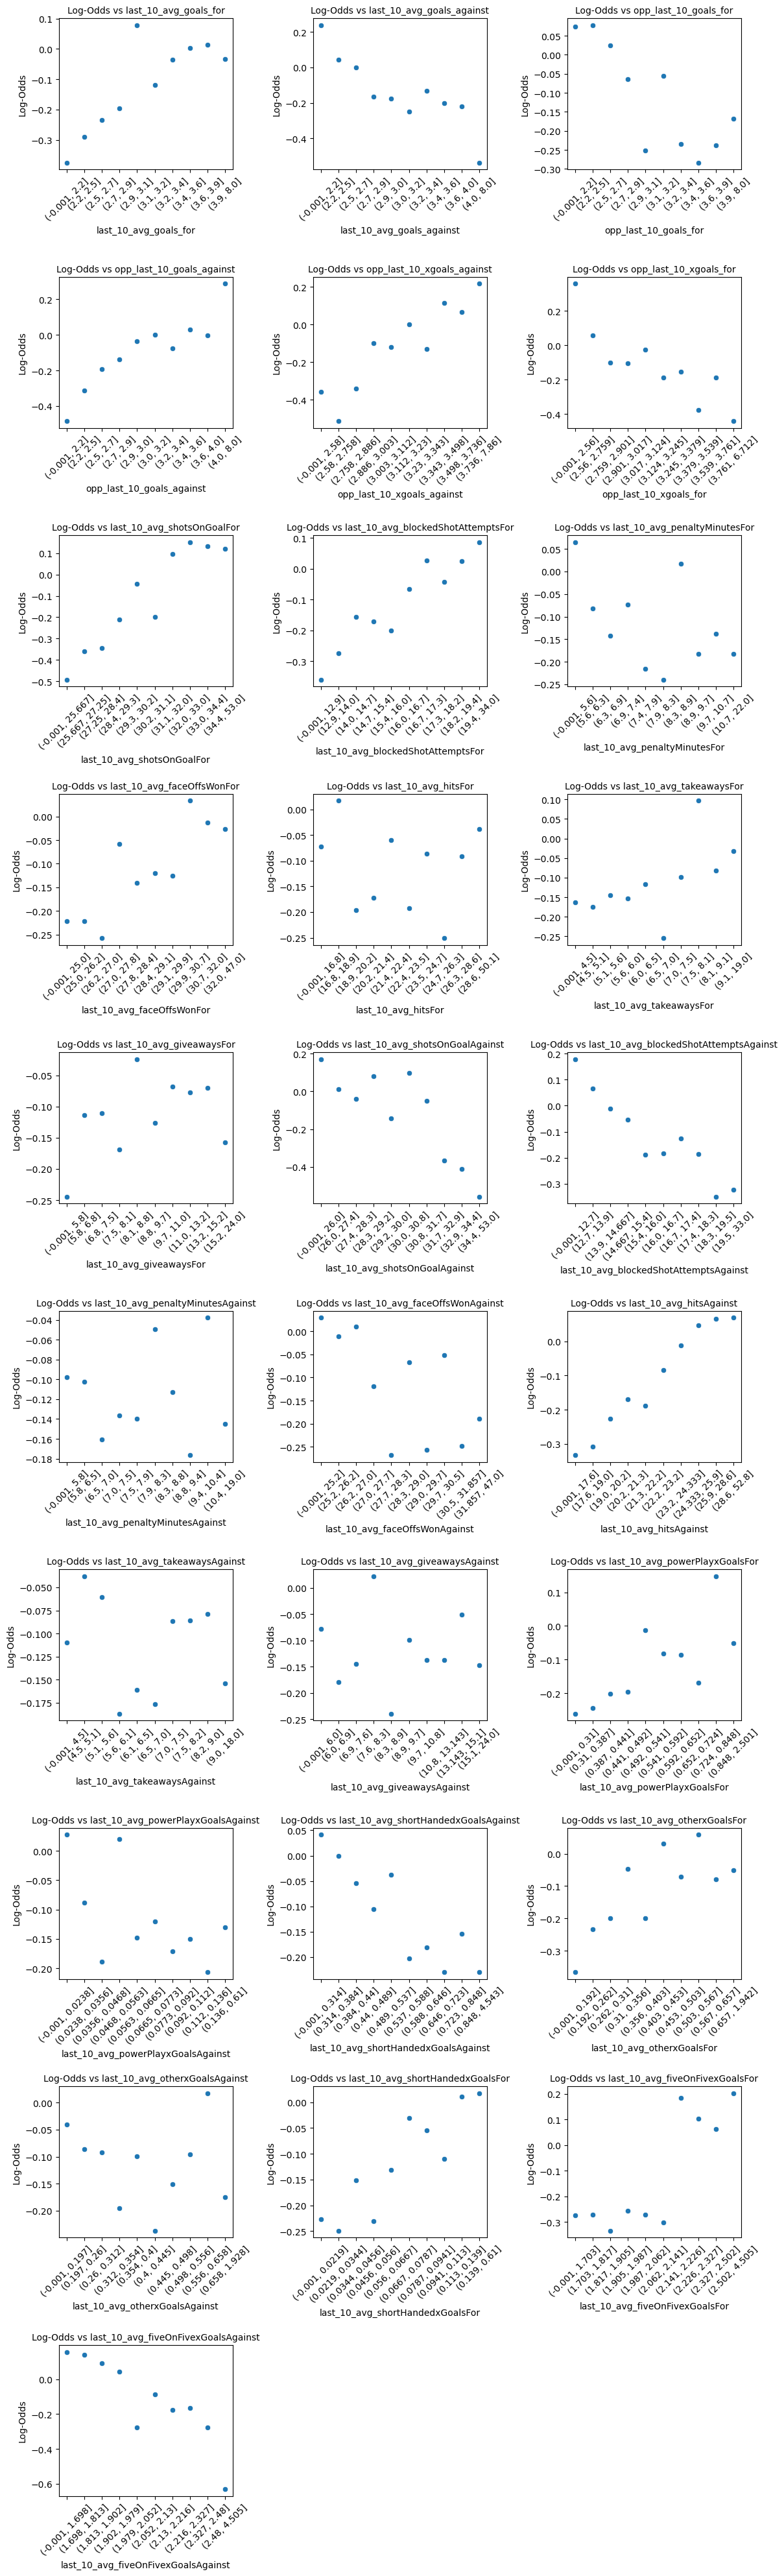

In [58]:
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

def plot_log_odds(X, y, feature, ax, bins=10, fontsize = 10, title_fontsize = 10, tick_fontsize = 10):
    """Plots the log-odds of a feature using binned values"""
    df = pd.DataFrame({feature: X[feature], 'target': y})

    # Bin the feature values to make interpretation of plots easier
    df['binned'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    
    grouped = df.groupby('binned', observed=False)['target'].agg(['mean', 'count'])
    grouped['log_odds'] = np.log(grouped['mean'] / (1 - grouped['mean']))
    
    sns.scatterplot(x=grouped.index.astype(str), y=grouped['log_odds'], ax=ax)
    
    ax.set_xticks(np.arange(len(grouped)))  # Explicitly set tick positions
    ax.set_xticklabels(grouped.index.astype(str), rotation=45)  # Set tick labels with rotation
    ax.set_xlabel(feature, fontsize = fontsize)
    ax.set_ylabel("Log-Odds", fontsize = fontsize)
    ax.set_title(f"Log-Odds vs {feature}", fontsize = title_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize) 

# Create a figure with subplots
X = X_train.drop(columns = ["home_away"])
numeric_features = X.columns.tolist()
n_plots = len(numeric_features)
n_cols = 3 
n_rows = (n_plots // n_cols) + (n_plots % n_cols != 0) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows)) 

axes = axes.flatten()

for i, feat in enumerate(numeric_features):
    plot_log_odds(X, y_train, feat, axes[i])

# Hide any unused axes
for i in range(n_plots, len(axes)):
    axes[i].axis('off')  # Hide extra subplots if there are more axes than features

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Based on the plots above, most of the features seem to have a linear relationship with the log odds of winning a game. However, some features seem to have no significant relationship such as `lat_10_avg_otherxGoalsAgainst`. Furthtermore, features such as `last_10_avg_takeaways_for` seem to have outliers which could potentially impact the results of the model.

Next we will perform hyper parameter optimization to determine the best values of each hyperparameter.

### Baseline Logistic Regression Model

We will first fit a baseline model to evaluate the results of a simple model.

In [34]:
baseline_model = LogisticRegression(random_state = 123)

In [49]:
cv_results = cross_validate(baseline_model, X_train_scaled, y_train, cv=5, return_train_score=True)

train_scores = cv_results['train_score']
cv_scores = cv_results['test_score']

print(f"Mean Train Accuracy: {train_scores.mean():.2f}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")

Mean Train Accuracy: 0.59
Mean Cross-Validation Accuracy: 0.58


The training and cross-validation accuracies above show that the model is not overfitting the data; however, it may be underfitting the data as the accuracies are on the lower side. We may need a more complex model to capture the patterns or select an entirely different model.

In [44]:
baseline_model.fit(X_train_scaled, y_train)

y_pred = baseline_model.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, baseline_model.predict_proba(X_test_scaled)[:, 1]))

Test Accuracy: 0.5721120984278879
Test AUC: 0.6092495990926536


The test accuracy and the area under the ROC curve further suggest that the model is only slightly better than randomly guessing. However, this may also be due to the nature of hockey game outcomes, where the outcomes can largely depend on randomness.

### Hyper Parameter Optimization

In [23]:
lr = LogisticRegression(max_iter = 1000, random_state = 123)

In [24]:
C_vals = 10.0 ** np.arange(-4, 4, 0.5)

param_grid = {
    'C' : C_vals,
    'penalty': ['l1','l2'],
    'max_iter': [100,200,500,100],
    'solver': ['liblinear', 'saga']
}

In [25]:
random_search = RandomizedSearchCV(lr,
                                  param_grid,
                                  n_iter = 100,
                                  n_jobs = -1,
                                  return_train_score = True)

random_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03]),
                                        'max_iter': [100, 200, 500, 100],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   return_train_score=True)

In [26]:
print(random_search.best_params_)

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'C': 0.01}


We see that based on randomized search out best value for C is 0.0003162, our best value for `max_iter` is 500, our best penalty is L2 (ridge regression) and our best solver is liblinear

In [27]:
best_train_score = random_search.cv_results_['mean_train_score'][random_search.best_index_]
print("Best Training Score:", best_train_score)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Training Score: 0.5919930086529105
Best Cross-Validation Score: 0.5819524549840519


To evaluate the performance of this model, we will compare it to the dummy classifier which predicts the most common class.

In [28]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train_scaled, y_train)

dummy_train_score = dummy_clf.score(X_train, y_train)
dummy_cv_score = cross_val_score(dummy_clf, X_train, y_train, cv=5).mean()

print(f"Dummy Training Score: {dummy_train_score:.4f}")
print(f"Dummy Cross-Validation Score: {dummy_cv_score:.4f}")

Dummy Training Score: 0.5288
Dummy Cross-Validation Score: 0.5288


Based on the cross validation score above, the logistic regression model is a slight improvement over the dummy classifier model which implies that the trained mmodel is learning meaningful patterns in the data and has prediticve power.

We will now evaluate the model on the test set and examine the predicted probabilities.

In [52]:
from sklearn.metrics import accuracy_score

best_model = random_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)

test_score = accuracy_score(y_test, y_pred)

print("Test Accuracy:", test_score)
print("Test AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1]))

Test Accuracy: 0.5762132604237867
Test AUC: 0.6106166274209357


In [45]:
pred_prob = best_model.predict_proba(X_test_scaled)
print(pred_prob[:10])

[[0.71057347 0.28942653]
 [0.58001876 0.41998124]
 [0.42056626 0.57943374]
 [0.4411421  0.5588579 ]
 [0.58791817 0.41208183]
 [0.6388922  0.3611078 ]
 [0.49551642 0.50448358]
 [0.60739423 0.39260577]
 [0.47014744 0.52985256]
 [0.5007023  0.4992977 ]]
Test AUC: 0.6106166274209357


As seen above, out prediction accuracy is 0.5762 which is slightly better than guessing randomly. However, the prediction accuracy is not particularly high. In addition, hyperperameter optimization only slightly increased the prediction accuracies and area under the curve which suggests we may opt for the simpler baseline model as it is easier to interpret.

One reason for the slightly low prediction accuracy may be a result of a lack of significant explanatory features. There could be additional features such as the opponents winning percentage or player specific data to help the model's accuracy. Furthermore, hockey game outcomes naturally come with a lot of randomness which makes it difficult to get high prediction accuracies. Moreover, we informally verified assumptions using scatterplots; however, there could be violations in our assumptions that we were not able to catch by merely observing those plots which could result in a lower model accuracy.